In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/itba-cifar-100-2024-q-1/y_train_fine.npy
/kaggle/input/itba-cifar-100-2024-q-1/y_train_coarse.npy
/kaggle/input/itba-cifar-100-2024-q-1/fine_label_names.pck
/kaggle/input/itba-cifar-100-2024-q-1/coarse_label_names.pck
/kaggle/input/itba-cifar-100-2024-q-1/x_test.npy
/kaggle/input/itba-cifar-100-2024-q-1/x_train.npy


In [2]:
x_train = np.load("/kaggle/input/itba-cifar-100-2024-q-1/x_train.npy")/255.
x_test = np.load("/kaggle/input/itba-cifar-100-2024-q-1/x_test.npy")/255.
y_train_coarse = np.load("/kaggle/input/itba-cifar-100-2024-q-1/y_train_coarse.npy")
y_train_fine = np.load("/kaggle/input/itba-cifar-100-2024-q-1/y_train_fine.npy")

In [3]:
import pickle
with open("/kaggle/input/itba-cifar-100-2024-q-1/fine_label_names.pck", "rb") as f:
    labels_fine = pickle.load(f)
with open("/kaggle/input/itba-cifar-100-2024-q-1/coarse_label_names.pck", "rb") as f:
    labels_coarse = pickle.load(f)

In [4]:
from matplotlib import pyplot as plt
%load_ext tensorboard

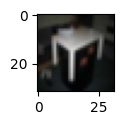

In [5]:
plt.figure(figsize=(1,1))
plt.imshow(x_train[25])

In [6]:
y_train_fine[25]

84

In [7]:
labels_fine[84]

'table'

In [8]:
# Me fijo para una categoría de grano grueso, cuáles son las categorías de grano fino
coarse = 6
print(f"Grano grueso: {labels_coarse[coarse]}")
for fine in np.unique(y_train_fine[y_train_coarse == coarse]):
    print(f"Grano fino: {labels_fine[fine]}")

Grano grueso: household_furniture
Grano fino: bed
Grano fino: chair
Grano fino: couch
Grano fino: table
Grano fino: wardrobe


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adam, AdamW, RMSprop
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard

2024-06-29 23:23:54.610138: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-29 23:23:54.610254: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-29 23:23:54.760418: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [10]:
x_train.shape

(50000, 32, 32, 3)

In [11]:
model = Sequential()
model.add(Flatten(input_shape=(32,32,3)))
model.add(BatchNormalization())
model.add(Dense(1536,activation = "leaky_relu",use_bias=True))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(100, activation= "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ["accuracy"], optimizer = Adam(learning_rate=0.001))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 3072)           │        12,288 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1536)           │     4,720,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │       153,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,892,260 (18.66 MB)

 Trainable params: 4,883,044 (18.63 MB)

 Non-trainable params: 9,216 (36.00 KB)

In [13]:
rlrop = ReduceLROnPlateau(
    monitor = "val_accuracy",
    factor = 0.5,
    patience = 2,
    verbose = 1,
    min_lr = 1e-7, 
)


In [14]:
mc = ModelCheckpoint(
    "best.weights.h5",
    monitor = "val_accuracy",
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
)

In [15]:
es = EarlyStopping(
    monitor = "val_accuracy",
    patience = 8, 
    verbose = 1,
    restore_best_weights = True,
)

In [16]:
data_val = ImageDataGenerator(validation_split = 0.2)

data_train = ImageDataGenerator(
    zoom_range = 0.2,
    horizontal_flip = True,
    validation_split = 0.2)

train_data = data_train.flow(x_train, y_train_fine, batch_size=64, subset='training')
val_data = data_val.flow(x_train, y_train_fine, batch_size=64, subset='validation')


In [17]:
tb = TensorBoard(
    log_dir="logs",
)

In [18]:
history = model.fit(
    train_data,
    epochs = 200,
    validation_data = val_data,
    callbacks= [rlrop, es, mc, tb]
)

Epoch 1/200


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  6/625 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.0282 - loss: 6.8072

I0000 00:00:1719703450.933490      69 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.0704 - loss: 5.0282
Epoch 1: val_accuracy improved from -inf to 0.14460, saving model to best.weights.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 33ms/step - accuracy: 0.0705 - loss: 5.0277 - val_accuracy: 0.1446 - val_loss: 3.9111 - learning_rate: 0.0010
Epoch 2/200
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.1089 - loss: 4.2627
Epoch 2: val_accuracy improved from 0.14460 to 0.16110, saving model to best.weights.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.1089 - loss: 4.2623 - val_accuracy: 0.1611 - val_loss: 3.7416 - learning_rate: 0.0010
Epoch 3/200
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.1321 - loss: 3.9669
Epoch 3: val_accuracy improved from 0.16110 to 0.16940, saving model to best.weights.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.1321 - loss: 3.9668 - val_accuracy: 0.1694 - val_loss: 3.6037 - learning_rate: 0.0010
Epoch 4/200
618/625 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - ac

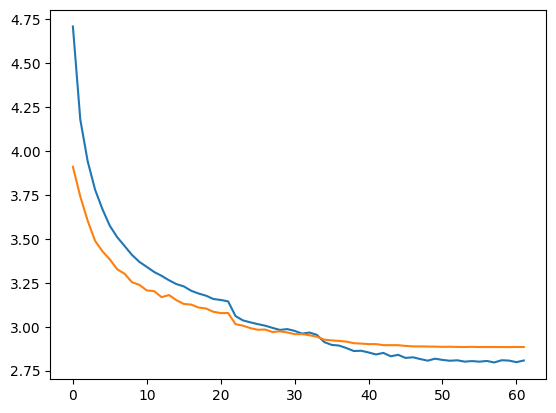

In [19]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

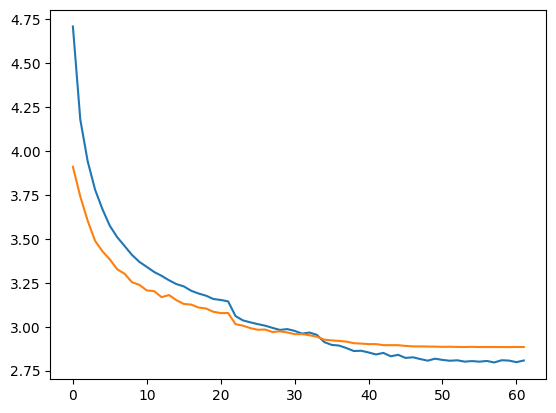

In [20]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

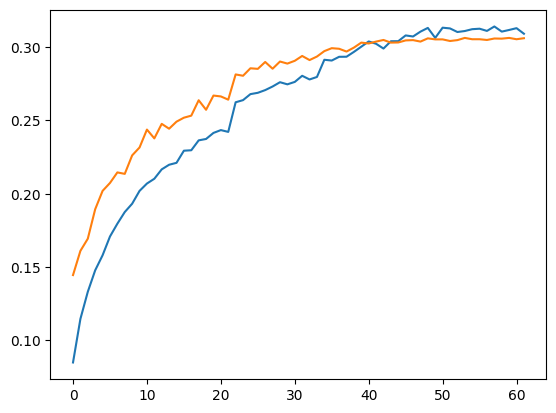

In [21]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

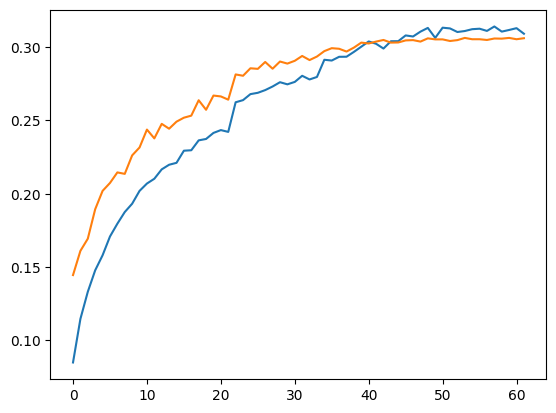

In [22]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

In [23]:
predictions = model.predict(x_test)

118/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

W0000 00:00:1719704672.812291      66 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [24]:
predictions = predictions.argmax(axis=1)

In [25]:
predictions

array([12, 42, 15, ..., 18, 42, 45])

In [26]:
df = pd.DataFrame(predictions, columns=["Label"])

In [27]:
df.index.name = "Id"

In [28]:
df.head()

,Label
Id,
0,12
1,42
2,15
3,40
4,71


In [29]:
df.to_csv("submission.csv")